# CS598 DL4H: Reproducibility Project Proposal for Graph Attention Networks model (Spring 2024)
Chaoran Zhou

cz78@illinois.edu

Group ID: 33

Paper ID: 13

Github: https://github.com/ranranrunforit/Reproducibility-Project

### Mount Notebook to Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# change the working directory to the Drive root
%cd /content/drive/My\ Drive

/content/drive/My Drive


# Introduction

## Background of the Problem

Many critical tasks involve data represented in irregular domains such as 3D meshes, social networks, telecommunication networks, biological networks, and brain connectomes, which can be modeled as graphs. Traditional Convolutional Neural Networks (CNNs) struggle with irregular data structures, leading to the introduction of Graph Neural Networks (GNNs) to handle general graphs. Attention mechanisms, widely used in sequence-based tasks, offer the flexibility to focus on relevant parts of varying inputs. Graph Attention Networks (GAT) represent a significant advancement in effectively applying neural network architectures to graph-structured data, particularly in scenarios where the data does not adhere to a grid-like structure.

## Paper Explanation

The paper introduces Graph Attention Networks (GAT) as an innovative approach to processing graph-structured data using convolution-style neural networks with masked self-attentional layers. GAT enables nodes to assign varying weights to their neighbors without costly matrix operations or prior knowledge of the entire graph structure. By leveraging attention mechanisms efficiently within the graph attentional layer, GAT achieves computational efficiency and can parallelize operations across all nodes in the graph. This dynamic assignment of node importance based on relationships leads to improved information propagation and feature learning, resulting in state-of-the-art performance on node classification benchmarks. GAT offers a more effective and scalable solution for handling complex relationships in graph data.


# Scope of Reproducibility:

Hypotheses

- Hypothesis 1: The GAT model is expected to achieve a mean classification accuracy of 83.0 ± 0.7% on transductive tasks using Cora datasets.

- Hypothesis 2: The GAT model is expected to achieve a mean classification accuracy of 72.5 ± 0.7% on transductive tasks using Citeseer datasets.

- Hypothesis 3: The GAT model is expected to achieve a mean microaveraged F1 score of 97.3 ± 0.2% on inductive tasks using PPI datasets.


It is important to note that the hypothesis has been adjusted based on the implementation and testing with the GAT model.

# Methodology


It is important to note that in each section of this draft report, two GAT models' codes are presented.

It is recommended to run one model's code at a time to accurately assess the performance of each model, given the time constraints of less than 8 minutes.

In [3]:
!nvidia-smi

Sun Apr 21 08:40:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
# Install library torch-torch-geometric
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.0 MB/s eta 0:00:00


##  Data

### Data descriptions

The project utilized three classic graph datasets, namely Cora, CiteSeer, and Protein-Protein Interactions (PPI) datasets.

For transductive learning, both Cora and CiteSeer Datasets were used, representing networks of research papers with each connection representing a citation. The Cora dataset consists of 2708 scientific publications classified into seven classes, with a citation network of 5429 links. Each publication is described by a word vector (node features) indicating the presence or absence of 1433 unique words in a paper. The CiteSeer dataset consists of 3327 scientific publications classified into six classes, with a citation network of 4732 links. Each publication is described by a word vector indicating the presence or absence of 3703 unique words.

For inductive learning, the PPI dataset contains 24 graphs corresponding to different human tissues, with 20 graphs for training, 2 for validation, and 2 for testing. The average number of nodes per graph is 2372, and each node has 50 features composed of positional gene sets, motif gene sets, and immunological signatures, as well as 121 labels from the Molecular Signatures Database.

### Implementation code

The data processing involves loading data from files for the Cora dataset, extracting features and labels, adapting the data to PyTorch format, creating an adjacency matrix, adding self-loops to the adjacency matrix, and transferring the data to the device. Similarly, for the Citeseer dataset, isolated nodes in the graph are identified and added as zero vectors, followed by the same data pre-processing steps as the Cora dataset.

The trained models' predictive power is evaluated on 1000 test nodes, with an additional 500 nodes used for validation. In the case of the Cora dataset, there are 140 training nodes, while the Citeseer dataset has 120 training nodes.


In [7]:
# Function to load Cora
import os
import time
import requests
import tarfile
import numpy as np
import argparse
import torch

def load_cora(path='./datasets/cora/', device='cpu'):

    # Set the paths to the data files
    content_path = os.path.join(path, 'cora.content')
    cites_path = os.path.join(path, 'cora.cites')

    # Load data from files
    content_tensor = np.genfromtxt(content_path, dtype=np.dtype(str))
    cites_tensor = np.genfromtxt(cites_path, dtype=np.int32)

    # Process features
    features = torch.FloatTensor(content_tensor[:, 1:-1].astype(np.int32)) # Extract feature values
    scale_vector = torch.sum(features, dim=1) # Compute sum of features for each node
    scale_vector = 1 / scale_vector # Compute reciprocal of the sums
    scale_vector[scale_vector == float('inf')] = 0 # Handle division by zero cases
    scale_vector = torch.diag(scale_vector).to_sparse() # Convert the scale vector to a sparse diagonal matrix
    features = scale_vector @ features # Scale the features using the scale vector

    # Process labels
    classes, labels = np.unique(content_tensor[:, -1], return_inverse=True) # Extract unique classes and map labels to indices
    labels = torch.LongTensor(labels) # Convert labels to a tensor

    # Process adjacency matrix
    idx = content_tensor[:, 0].astype(np.int32) # Extract node indices
    idx_map = {id: pos for pos, id in enumerate(idx)} # Create a dictionary to map indices to positions

    # Map node indices to positions in the adjacency matrix
    edges = np.array(
        list(map(lambda edge: [idx_map[edge[0]], idx_map[edge[1]]],
            cites_tensor)), dtype=np.int32)

    V = len(idx) # Number of nodes
    E = edges.shape[0] # Number of edges
    adj_mat = torch.sparse_coo_tensor(edges.T, torch.ones(E), (V, V), dtype=torch.int64) # Create the initial adjacency matrix as a sparse tensor
    adj_mat = torch.eye(V) + adj_mat # Add self-loops to the adjacency matrix

    return features.to(device), labels.to(device), adj_mat.to(device)

In [8]:
import torch
import os
import requests
import tarfile
import glob

# Set the parameters directly
args = {
    'seed': 9,
    'no_cuda': False,
    'no_mps': False,
    'hidden_dim': 64,
    'num_heads': 8,
    'concat_heads': False,
    'dropout_p': 0.6,
    'lr': 0.005,
    'l2': 5e-4,
    'epochs': 200,
}

torch.manual_seed(args['seed'])
use_cuda = not args['no_cuda'] and torch.cuda.is_available()
use_mps = not args['no_mps'] and torch.backends.mps.is_available()

# Set the device to run on
if use_cuda:
    device = torch.device('cuda')
elif use_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} device')

# Load the cora dataset
features, labels, adj_mat = load_cora(device=device)
# Split the dataset into training, validation, and test sets
idx = torch.randperm(len(labels)).to(device)
idx_test, idx_val, idx_train = idx[:1200], idx[1200:1600], idx[1600:]

Using cpu device


In [16]:
# Function to load CiteSeer
# (This is for the demonstration, you can run it. However running this cell will add chance to exceed the 8 minutes limits depends on the device )
import os
import time
import requests
import tarfile
import numpy as np
import argparse

import torch

def preprocess_index(cites_data, content_data):
    # Fix citeseer dataset (there are some isolated nodes in the graph)
    # Find isolated nodes, add them as zero-vecs into the right position

    # Get unique IDs from both files
    content_ids = np.unique(content_data[:, 0])
    cites_ids = np.unique(np.concatenate((cites_data[:, 0], cites_data[:, 1])))

    # Create ID mappings
    content_id_mapping = dict(zip(content_ids, range(len(content_ids))))
    cites_id_mapping = {id: content_id_mapping.get(id, len(content_id_mapping) + idx) for idx, id in enumerate(np.setdiff1d(cites_ids, content_ids))}
    len_diff = len(cites_id_mapping)
    cites_id_mapping.update(content_id_mapping)

    # Update IDs in .cites file
    cites_data[:, 0] = [cites_id_mapping[id] for id in cites_data[:, 0]]
    cites_data[:, 1] = [cites_id_mapping[id] for id in cites_data[:, 1]]

    # Update IDs in .content file
    content_data[:, 0] = [content_id_mapping[id] for id in content_data[:, 0]]
    # Add len_diff rows to content_data
    additional_rows = np.zeros((len_diff, content_data.shape[1]),  dtype=content_data.dtype)
    additional_rows[:, 1:-1] = np.array([['0'] * (content_data.shape[1] - 2)] * len_diff)
    additional_rows[:, 0] = np.arange(len(content_ids), len(content_ids) + len_diff)
    additional_rows[:, -1] = np.array(['NONE'] * len_diff)

    new_content_data = np.vstack((content_data, additional_rows))

    return new_content_data, cites_data.astype(np.int64)

def load_citeseer(path='./datasets/citeseer/', device='cpu'):

    # Set the paths to the data files
    content_path = os.path.join(path, 'citeseer.content')
    cites_path = os.path.join(path, 'citeseer.cites')

    # Load data from files
    content_data = np.genfromtxt(content_path, dtype=np.dtype(str))
    cites_data = np.genfromtxt(cites_path, dtype=np.dtype(str))

    content_tensor, cites_tensor = preprocess_index(cites_data, content_data)

    # Process features
    features = torch.FloatTensor(content_tensor[:, 1:-1].astype(np.int32)) # Extract feature values
    scale_vector = torch.sum(features, dim=1) # Compute sum of features for each node
    scale_vector = 1 / scale_vector # Compute reciprocal of the sums
    scale_vector[scale_vector == float('inf')] = 0 # Handle division by zero cases
    scale_vector = torch.diag(scale_vector).to_sparse() # Convert the scale vector to a sparse diagonal matrix
    features = scale_vector @ features # Scale the features using the scale vector

    # Process labels
    classes, labels = np.unique(content_tensor[:, -1], return_inverse=True) # Extract unique classes and map labels to indices
    labels = torch.LongTensor(labels) # Convert labels to a tensor

    # Process adjacency matrix
    idx = content_tensor[:, 0].astype(np.int32) # Extract node indices
    idx_map = {id: pos for pos, id in enumerate(idx)} # Create a dictionary to map indices to positions

    # Map node indices to positions in the adjacency matrix
    edges = np.array(
        list(map(lambda edge: [idx_map[edge[0]], idx_map[edge[1]]],
            cites_tensor)), dtype=np.int32)

    V = len(idx) # Number of nodes
    E = edges.shape[0] # Number of edges
    adj_mat = torch.sparse_coo_tensor(edges.T, torch.ones(E), (V, V), dtype=torch.int64) # Create the initial adjacency matrix as a sparse tensor
    adj_mat = torch.eye(V) + adj_mat # Add self-loops to the adjacency matrix

    # return features.to_sparse().to(device), labels.to(device), adj_mat.to_sparse().to(device)
    return features.to(device), labels.to(device), adj_mat.to(device)

In [17]:
# Load the citeseer dataset
# (This is for the demonstration, you can run it. However running this cell will add chance to exceed the 8 minutes limits depends on the device )
features, labels, adj_mat = load_citeseer(device=device)
# Split the dataset into training, validation, and test sets
idx = torch.randperm(len(labels)).to(device)
idx_test, idx_val, idx_train = idx[:1000], idx[1000:1500], idx[1500:]

For inductive learning using the PPI dataset, the data and dataloader were directly loaded from the torch_geometric library. The dataset contained 20 graphs for training, 2 for validation, and 2 for testing, with a batch size of 2 graphs utilized during training.

In [5]:
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import AddSelfLoops

# Load the PPI dataset
train_dataset = PPI(root='', split='train', transform=AddSelfLoops())
val_dataset = PPI(root='', split='val', transform=AddSelfLoops())
test_dataset = PPI(root='', split='test', transform=AddSelfLoops())

num_features = 50
num_labels = 121
train_loader = DataLoader(train_dataset, batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

Extracting ./ppi.zip
Processing...
Done!


##   Model
###  Model descriptions
The model architecture for Graph Attention Networks (GAT) as proposed by Veličković et al. consists of two main model configurations, transductive learning model on Cora and Citeseer datasets, and inductive learning model on the PPI dataset. Both models are initialized using Glorot initialization and trained to minimize cross-entropy on the training nodes using the Adam SGD optimizer with an initial learning rate of 0.005 for all datasets. In both cases, an early stopping strategy is employed on both the cross-entropy loss and accuracy (transductive) or micro-F1 (inductive) score on the validation nodes, with a patience of 100 epochs.

For transductive learning, a two-layer GAT model is applied. The first layer consists of K = 8 attention heads computing F = 8 features each, followed by an exponential linear unit (ELU) nonlinearity. This results in a total of 64 features. The second layer is used for classification and consists of a single attention head that computes C features, where C is the number of classes, followed by a softmax activation. To address the small training set sizes, regularization is applied within the model. Specifically, L2 regularization with lambda = 0.0005 is applied during training. Additionally, dropout with p = 0.6 is applied to both layers’ inputs, as well as to the normalized attention coefficients.
The architectural hyperparameters have been optimized on the Cora dataset and then reused for the Citeseer dataset.

For inductive learning, a three-layer GAT model is applied. Both of the first two layers consist of K = 4 attention heads computing F = 256 features each, followed by an ELU nonlinearity, resulting in a total of 1024 features. The final layer is used for (multi-label) classification and consists of K = 6 attention heads computing 121 features each, which are averaged and followed by a logistic sigmoid activation. In this case, the training sets are sufficiently large, and there is no need to apply L2 regularization or dropout. However, skip connections across the intermediate attentional layer have been successfully employed. A batch size of 2 graphs is utilized during training for this task.


Reference


```
@article{
  velickovic2018graph,
  title="{Graph Attention Networks}",
  author={Veli{\v{c}}kovi{\'{c}}, Petar and Cucurull, Guillem and Casanova, Arantxa and Romero, Adriana and Li{\`{o}}, Pietro and Bengio, Yoshua},
  journal={International Conference on Learning Representations},
  year={2018},
  url={https://openreview.net/forum?id=rJXMpikCZ},
}
```
- Paper on arxiv: [arXiv:1710.10903v3](https://doi.org/10.48550/arXiv.1710.10903)
- Original paper repository: [https://github.com/PetarV-/GAT](https://github.com/PetarV-/GAT)



### Implementation code

For transductive learning GAT:

In [9]:
# implementation of GAT for Cora, Citeseer dataset
import torch
from torch import nn
import torch.nn.functional as F

class GraphAttentionLayer(nn.Module):
    """
    Graph Attention Layer (GAT) as described in the paper `"Graph Attention Networks" <https://arxiv.org/pdf/1710.10903.pdf>`.

        This operation can be mathematically described as:

            e_ij = a(W h_i, W h_j)
            α_ij = softmax_j(e_ij) = exp(e_ij) / Σ_k(exp(e_ik))
            h_i' = σ(Σ_j(α_ij W h_j))

            where h_i and h_j are the feature vectors of nodes i and j respectively, W is a learnable weight matrix,
            a is an attention mechanism that computes the attention coefficients e_ij, and σ is an activation function.

    """
    def __init__(self, in_features: int, out_features: int, n_heads: int, concat: bool = False, dropout: float = 0.4, leaky_relu_slope: float = 0.2):
        super(GraphAttentionLayer, self).__init__()

        self.n_heads = n_heads # Number of attention heads
        self.concat = concat # wether to concatenate the final attention heads
        self.dropout = dropout # Dropout rate

        if concat: # concatenating the attention heads
            self.out_features = out_features # Number of output features per node
            assert out_features % n_heads == 0 # Ensure that out_features is a multiple of n_heads
            self.n_hidden = out_features // n_heads
        else: # averaging output over the attention heads (Used in the main paper)
            self.n_hidden = out_features

        #  A shared linear transformation, parametrized by a weight matrix W is applied to every node
        #  Initialize the weight matrix W
        self.W = nn.Parameter(torch.empty(size=(in_features, self.n_hidden * n_heads)))

        # Initialize the attention weights a
        self.a = nn.Parameter(torch.empty(size=(n_heads, 2 * self.n_hidden, 1)))

        self.leakyrelu = nn.LeakyReLU(leaky_relu_slope) # LeakyReLU activation function
        self.softmax = nn.Softmax(dim=1) # softmax activation function to the attention coefficients

        self.reset_parameters() # Reset the parameters


    def reset_parameters(self):
        """
        Reinitialize learnable parameters.
        """
        nn.init.xavier_normal_(self.W)
        nn.init.xavier_normal_(self.a)


    def forward(self,  h: torch.Tensor, adj_mat: torch.Tensor):
        """
        Performs a graph attention layer operation.

        Args:
            h (torch.Tensor): Input tensor representing node features.
            adj_mat (torch.Tensor): Adjacency matrix representing graph structure.

        Returns:
            torch.Tensor: Output tensor after the graph convolution operation.
        """
        n_nodes = h.shape[0]

        # Apply linear transformation to node feature -> W h
        # output shape (n_nodes, n_hidden * n_heads)
        h_transformed = torch.mm(h, self.W)
        h_transformed = F.dropout(h_transformed, self.dropout, training=self.training)

        # splitting the heads by reshaping the tensor and putting heads dim first
        # output shape (n_heads, n_nodes, n_hidden)
        h_transformed = h_transformed.view(n_nodes, self.n_heads, self.n_hidden).permute(1, 0, 2)

        # getting the attention scores
        # output shape (n_heads, n_nodes, n_nodes)
        # e = self._get_attention_scores(h_transformed) ORGINIAL
        source_scores = torch.matmul(h_transformed, self.a[:, :self.n_hidden, :])
        target_scores = torch.matmul(h_transformed, self.a[:, self.n_hidden:, :])

        # broadcast add
        # (n_heads, n_nodes, 1) + (n_heads, 1, n_nodes) = (n_heads, n_nodes, n_nodes)
        e = source_scores + target_scores.mT
        e = self.leakyrelu(e)

        # Set the attention score for non-existent edges to -9e15 (MASKING NON-EXISTENT EDGES)
        connectivity_mask = -9e16 * torch.ones_like(e)
        e = torch.where(adj_mat > 0, e, connectivity_mask) # masked attention scores

        # attention coefficients are computed as a softmax over the rows
        # for each column j in the attention score matrix e
        attention = F.softmax(e, dim=-1)
        attention = F.dropout(attention, self.dropout, training=self.training)

        # final node embeddings are computed as a weighted average of the features of its neighbors
        h_prime = torch.matmul(attention, h_transformed)

        # concatenating/averaging the attention heads
        # output shape (n_nodes, out_features)
        if self.concat:
            h_prime = h_prime.permute(1, 0, 2).contiguous().view(n_nodes, self.out_features)
        else:
            h_prime = h_prime.mean(dim=0)

        return h_prime

class GAT(nn.Module):
    """
    Graph Attention Network (GAT) as described in the paper `"Graph Attention Networks" <https://arxiv.org/pdf/1710.10903.pdf>`.
    Consists of a 2-layer stack of Graph Attention Layers (GATs). The fist GAT Layer is followed by an ELU activation.
    And the second (final) layer is a GAT layer with a single attention head and softmax activation function.
    """
    def __init__(self,
        in_features,
        n_hidden,
        n_heads,
        num_classes,
        concat=False,
        dropout=0.4,
        leaky_relu_slope=0.2):
        """ Initializes the GAT model.

        Args:
            in_features (int): number of input features per node.
            n_hidden (int): output size of the first Graph Attention Layer.
            n_heads (int): number of attention heads in the first Graph Attention Layer.
            num_classes (int): number of classes to predict for each node.
            concat (bool, optional): Wether to concatinate attention heads or take an average over them for the
                output of the first Graph Attention Layer. Defaults to False.
            dropout (float, optional): dropout rate. Defaults to 0.4.
            leaky_relu_slope (float, optional): alpha (slope) of the leaky relu activation. Defaults to 0.2.
        """

        super(GAT, self).__init__()

        # Define the Graph Attention layers
        self.gat1 = GraphAttentionLayer(
            in_features=in_features, out_features=n_hidden, n_heads=n_heads,
            concat=concat, dropout=dropout, leaky_relu_slope=leaky_relu_slope
            )

        self.gat2 = GraphAttentionLayer(
            in_features=n_hidden, out_features=num_classes, n_heads=1,
            concat=False, dropout=dropout, leaky_relu_slope=leaky_relu_slope
            )

    def forward(self, input_tensor: torch.Tensor , adj_mat: torch.Tensor):
        """
        Performs a forward pass through the network.

        Args:
            input_tensor (torch.Tensor): Input tensor representing node features.
            adj_mat (torch.Tensor): Adjacency matrix representing graph structure.

        Returns:
            torch.Tensor: Output tensor after the forward pass.
        """

        # Apply the first Graph Attention layer
        x = self.gat1(input_tensor, adj_mat)
        x = F.elu(x) # Apply ELU activation function to the output of the first layer

        # Apply the second Graph Attention layer
        x = self.gat2(x, adj_mat)

        return F.log_softmax(x, dim=1) # Apply log softmax activation function

In [10]:
import os
import time
import requests
import tarfile
import numpy as np
import argparse

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
# train function


def train_iter(epoch, model, optimizer, criterion, input, target, mask_train, mask_val):
    start_t = time.time()
    model.train()
    optimizer.zero_grad()

    # Forward pass
    output = model(*input)
    loss = criterion(output[mask_train], target[mask_train])  # Compute the loss using the training mask

    loss.backward()
    optimizer.step()

    # Evaluate the model performance on training and validation sets
    loss_train, acc_train = evaluate(model, criterion, input, target, mask_train)
    loss_val, acc_val = evaluate(model, criterion, input, target, mask_val)

    #if epoch % print_every == 0:
        # Print the training progress at specified intervals
    # print(f'Epoch: {epoch:04d} ({(time.time() - start_t):.4f}s) loss_train: {loss_train:.4f} acc_train: {acc_train:.4f} loss_val: {loss_val:.4f} acc_val: {acc_val:.4f}')
    # Print the training progress
    print(" | ".join([f"Epoch: {(epoch + 1) :04d}", f"time: {(time.time() - start_t):.4f}s", f"Train loss: {loss_train:.4f}",
                          f"Train Accuracy: {acc_train:.4f}",
                          f"Val loss: {loss_val:.4f}",
                          f"Val Accuracy: {acc_val:.4f}"]))

    return loss_train, acc_train, loss_val, acc_val


def training_and_evaluate(model, input, target, mask_train, mask_val, epochs):
    print('Training model...')
    optimizer = Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
    # model.to(device).reset_parameters()
    # model.reset_parameters()
    criterion = nn.NLLLoss()

    t_total = time.time()
    loss_values = []
    acc_values = []

    best_val_acc = 0.0
    best_val_loss = np.inf
    curr_step = 0

    best_model_state_dict = None
    best_optimizer_state_dict = None

    best = -1
    best_epoch = 0

    for epoch in range(epochs):
      # Evaluate the model performance on training and validation sets
      loss_train, acc_train, loss_val, acc_val = train_iter(epoch, model, optimizer, criterion, (features, adj_mat), labels, idx_train, idx_val)

      loss_values.append(loss_val)
      acc_values.append(acc_val)


      #if print_result:
      #    print(f'Epoch: {epoch + 1:04d} ({(time.time() - start_t):.4f}s) loss_train: {loss_train:.4f} acc_train: {acc_train:.4f} loss_val: {loss_val:.4f} acc_val: {acc_val:.4f}')

      if acc_val > best_val_acc or loss_val < best_val_loss:
        best_val_acc = max(acc_val, best_val_acc)
        best_val_loss = min(loss_val, best_val_loss)
        best_model_state_dict = model.state_dict()
        best_optimizer_state_dict = optimizer.state_dict()
        best_epoch = epoch
        curr_step = 0
        best_so_far = True
      else:
        curr_step += 1
        best_so_far = False

      if best_so_far:
        torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state_dict,
                'optimizer_state_dict': best_optimizer_state_dict,
            }, 'GAT')

      '''
      if curr_step >= patience:
        print()
        print('Early stopping condition met. Stopped at Epoch {:04d}: '.format(epoch + 1))
        print(f'Best Validation Loss: {best_val_loss:.4f}, Best Validation Accuracy: {best_val_acc:.4f}')
        break
      '''

    print()
    print(f"Total time elapsed: {(time.time() - t_total):.4f}s  |  Average time elapsed: {((time.time() - t_total)/epochs):.4f}s")

    # Restore best model
    print()
    print('Loading best performance model {}th epoch'.format(best_epoch + 1))
    state = torch.load('GAT')
    model.load_state_dict(state['model_state_dict'])
    loss_test, acc_test = evaluate(model, criterion, (features, adj_mat), labels, idx_test)
    print(f'Test set results: Loss {loss_test:.4f}  |  Accuracy {acc_test:.4f}')
    return model, loss_values, acc_values, loss_test, acc_test


# evaluate function
def evaluate(model, criterion, input, target, mask):
    # model = model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(*input)
        output, target = output[mask], target[mask]

        loss = criterion(output, target)
        acc = (output.argmax(dim=1) == target).float().sum() / len(target)

    return loss.item(), acc.item()

In [11]:
# Create the model
# The model consists of a 2-layer stack of Graph Attention Layers (GATs).
GAT_cora = GAT(
    in_features=features.shape[1],          # Number of input features per node
    n_hidden=args['hidden_dim'],            # Output size of the first Graph Attention Layer
    n_heads=args['num_heads'],               # Number of attention heads in the first Graph Attention Layer
    num_classes=labels.max().item() + 1,     # Number of classes to predict for each node
    concat=args['concat_heads'],             # Whether to concatenate attention heads
    dropout=args['dropout_p'],                # Dropout rate
    leaky_relu_slope=0.2                     # Alpha (slope) of the leaky ReLU activation
).to(device)

In [27]:
# Create the model
# The model consists of a 2-layer stack of Graph Attention Layers (GATs).
GAT_citeseer = GAT(
    in_features=features.shape[1],          # Number of input features per node
    n_hidden=args['hidden_dim'],            # Output size of the first Graph Attention Layer
    n_heads=args['num_heads'],               # Number of attention heads in the first Graph Attention Layer
    num_classes=labels.max().item() + 1,     # Number of classes to predict for each node
    concat=args['concat_heads'],             # Whether to concatenate attention heads
    dropout=args['dropout_p'],                # Dropout rate
    leaky_relu_slope=0.2                     # Alpha (slope) of the leaky ReLU activation
).to(device)

For Inductive Learning GAT:

In [6]:
# implementation of GAT for PPI dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import softmax, scatter
import numpy as np

def glorot(value, name=None):
    """Glorot & Bengio (AISTATS 2010) init."""
    init_range = np.sqrt(6.0 / (value.size(-2) + value.size(-1)))
    initial = value.data.uniform_(-init_range, init_range)
    return nn.Parameter(initial, requires_grad=True)

class GATLayer(nn.Module):

  def __init__(self,
               D_in: int,
               D_out: int,
               num_heads: int = 1,
               act=F.elu,
               dropout: float = 0.0,
               reduce='none',
               skip=False):
    super().__init__()
    self.D_in = D_in
    self.D_out = D_out
    self.N_h = num_heads
    self.act = act

    self.W = nn.Parameter(torch.zeros((num_heads, D_out, D_in)))
    self.W_skip = nn.Parameter(torch.zeros((num_heads, D_out, D_in)))
    self.A_src = nn.Parameter(torch.zeros((num_heads, D_out, 1)))
    self.A_tgt = nn.Parameter(torch.zeros((num_heads, D_out, 1)))

    self.reduce = reduce
    self.dropout = dropout
    self.skip = skip

    self.reset_parameters()

  def reset_parameters(self):
    glorot(self.W)
    glorot(self.W_skip)
    glorot(self.A_src)
    glorot(self.A_tgt)


  def forward(self, H_in: torch.tensor, edge_index: torch.tensor) -> torch.tensor:
    edge_src, edge_tgt = edge_index

    N, _ = H_in.shape
    W = self.W
    W_skip = self.W_skip

    A_src = self.A_src
    A_tgt = self.A_tgt
    D_in = self.D_in
    D_out = self.D_out
    N_h = self.N_h
    act = self.act
    dropout = self.dropout
    training = self.training
    skip = self.skip

    W = W.view((N_h, D_out, D_in))
    W_skip = W.view((N_h, D_out, D_in))

    A_src = A_src.view((N_h, D_out))
    A_tgt = A_tgt.view((N_h, D_out))

    H_in = F.dropout(H_in, dropout, training)

    # H_w = torch.matmul(H_in, W.transpose(1, 2)) # works too!
    H_w = torch.matmul(H_in, W.permute(0, 2, 1)) # works too!

    H_w = F.dropout(H_w, dropout, training)  # (N_h, |V|, D_out)


    H_w_src = H_w[:, edge_src]
    H_w_tgt = H_w[:, edge_tgt]


    E_pre_src = torch.matmul(H_w_src, A_src.unsqueeze(-1)).squeeze()
    E_pre_tgt = torch.matmul(H_w_tgt, A_tgt.unsqueeze(-1)).squeeze()

    E_pre = E_pre_src + E_pre_tgt  # (N_h, |E|, 1), a^T [Whi || Whj]
    E = F.leaky_relu(E_pre, negative_slope=0.2)  # (N_h, |E|, 1), LeakyRelu(a^T [Whi || Whj])

    alpha_scores = softmax(E, edge_tgt, dim=1).view((N_h, *edge_src.shape, 1))  # (N_h, |E|, 1)


    alpha_scores = F.dropout(alpha_scores, dropout, training)
    Alpha = alpha_scores.repeat(1, 1, D_out)  # (N_h, |E|, D_out)

    self.attention_scores = alpha_scores

    H_out_pre = scatter(Alpha * H_w_src, edge_tgt, dim=1, reduce='sum')  # (N_h, |V|, D_out)

    if skip:
      H_skip_to_add = torch.zeros_like(H_out_pre)
      if D_in != D_out:
        H_skip_to_add = torch.matmul(H_in, W_skip.transpose(1, 2))
      else:
        H_skip_to_add = H_in.repeat(N_h, 1, 1)

      H_out_pre += H_skip_to_add

    if self.reduce == 'none':
      H_out = act(H_out_pre)  # (N_h, |V|, D_out)
      assert (H_out.shape == (N_h, N, D_out))
      return H_out
    elif self.reduce == 'concat':
      H_out = act(H_out_pre)
      H_out_per_head = torch.tensor_split(H_out, N_h)
      H_out_cat = torch.cat(H_out_per_head, dim=-1).squeeze()
      self.embeddings = H_out_cat
      assert (H_out_cat.shape == (N, N_h * D_out))
      return H_out_cat
    else:
      H_out_pre_avg = torch.mean(H_out_pre, dim=0)
      H_out = act(H_out_pre_avg)
      self.embeddings = H_out
      assert (H_out.shape == (N, D_out))
      return H_out



class GAT_PPI(nn.Module):

  def __init__(self, dim_in: int, num_classes: int):
    super().__init__()
    self.model_name = 'GAT_PPI'
    self.layers = nn.ModuleList([
        GATLayer(dim_in, 256, 4, act=F.elu, reduce='concat'),
        GATLayer(1024, 256, 4, act=F.elu, reduce='concat', skip=True),
        GATLayer(1024, num_classes, 6, act=nn.Identity(), reduce='avg', skip=True)
    ])
    self.reset_parameters()

  def forward(self, X: torch.tensor, edge_index: torch.tensor) -> torch.tensor:
    out = X
    for layer in self.layers:
      out = layer(out, edge_index)
    return out

  def reset_parameters(self):
    for layer in self.layers:
      layer.reset_parameters()


In [7]:
# evaluate function
# set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch
import torch.nn as nn
from sklearn.metrics import f1_score
import numpy as np

def evaluate(model, batch_loader):
    # model = model.to(device)

    loss_fcn = nn.BCEWithLogitsLoss()

    total_score = 0
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for (batch_id, batched_graph) in enumerate(batch_loader):
            node_features = batched_graph.x.to(device)
            edge_index = batched_graph.edge_index.to(device)
            labels = batched_graph.y.to(device)

            logits = model(node_features, edge_index)
            pred = (logits >= 0).float().cpu().numpy() # torch.where(logits >= 0, 1, 0)
            loss = loss_fcn(logits, labels)
            score = torch.tensor(f1_score(labels.cpu().numpy(), pred, average='micro'), dtype=torch.float32, device=device) #

        total_loss += loss.item()
        total_score += score.item()

    avg_loss = total_loss / (batch_id + 1)
    avg_score = total_score / (batch_id + 1)

    return avg_loss, avg_score

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_one_iter(train_batch, model, loss_func, optimizer):
    model.train()

    node_features, edge_index, labels = (train_batch.x.to(device), train_batch.edge_index.to(device),
                                         train_batch.y.to(device))

    # perform training step
    optimizer.zero_grad()
    logits = model(node_features, edge_index)
    pred = torch.where(logits >= 0, 1, 0)
    loss = loss_func(logits, labels)
    loss.backward()
    optimizer.step()

    pred_np = pred.cpu().numpy()
    labels_np = labels.cpu().numpy()
    f1 = f1_score(labels_np, pred_np, average='micro')

    return (loss.item(), torch.tensor(f1, dtype=torch.float32, device=device).item())

def training_loop(model, params: dict, verbose: bool = True) -> torch.nn.Module:
    #print('training model {}'.format(params['model_name']))
    #print(model)
    print('Training model...')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    model.reset_parameters()
    batch_criterion = nn.BCEWithLogitsLoss()

    # Train model
    t_total = time.time()
    best_f1 = -1
    best_loss = pow(10, 9)
    patience = params['patience']
    underperformed = 0

    train_losses, train_scores = [], []
    val_losses, val_scores = [], []

    best_model_state_dict = None
    best_optimizer_state_dict = None
    best_epoch = 0

    for epoch in range(params['epochs']):
        start_t = time.time()
        model.train()
        total_train_loss = 0
        total_train_score = 0

        for (batch_ix, batch) in enumerate(train_loader):

            batch_loss, batch_score = train_one_iter(batch, model, batch_criterion, optimizer )
            total_train_loss += batch_loss
            total_train_score += batch_score

        avg_train_loss = total_train_loss / (batch_ix + 1)
        avg_train_score = total_train_score / (batch_ix + 1)

        val_loss, val_score = evaluate(model, val_loader)

        if verbose:
            # print('epoch {:05d}'.format(epoch + 1))
            # print('\t{}_loss: {:.4f} | {}_micro_f1: {:.4f}'.format('train', avg_train_loss,'train', avg_train_score))
            # print('\t{}_loss: {:.4f} | {}_micro_f1: {:.4f}'.format('val', val_loss,'val', val_score))
            print(" | ".join([f"Epoch: {(epoch + 1) :04d}", f"time: {(time.time() - start_t):.4f}s", f"Train loss: {avg_train_loss:.4f}",
                          f"Train micro F1: {avg_train_score:.4f}",
                          f"Val loss: {val_loss:.4f}",
                          f"Val micro F1: {val_score:.4f}"]))

        train_losses.append(avg_train_loss)
        train_scores.append(avg_train_loss)
        val_losses.append(val_loss)
        val_scores.append(val_score)

        if (val_score > best_f1 or val_loss < best_loss):
            best_f1 = max(best_f1, val_score)
            best_loss = min(best_loss, val_loss)
            underperformed = 0
            was_best_so_far = True
            best_model_state_dict = model.state_dict()
            best_optimizer_state_dict = optimizer.state_dict()
            best_epoch = epoch
        else:
            underperformed += 1
            was_best_so_far = False

        if underperformed >= patience:
            print('Early stopping condition met. Stopped at Epoch {:04d}: '.format(epoch + 1))
            break

        if was_best_so_far:
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state_dict,
                'optimizer_state_dict': best_optimizer_state_dict,
            }, params['model_name'])


    print()
    #print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    print(f"Total time elapsed: {(time.time() - t_total):.4f}s  |  Average time elapsed: {((time.time() - t_total)/params['epochs']):.4f}s")

    state = torch.load(params['model_name'])
    model.load_state_dict(state['model_state_dict'])
    model.eval()

    best_epoch, best_model = state['epoch'], model
    best_val_loss, best_val_score = evaluate(model, val_loader)
    best_test_loss, best_test_score = evaluate(model, test_loader)

    print()
    print('Best model performance @ Epoch {:04d}: '.format(best_epoch + 1))
    print(f"Test loss: {best_test_loss:.4f}  |  Test micro F1: {best_test_score:.4f}")
    #print('\t{}_loss: {:.4f} | {}_micro_f1: {:.4f}'.format('val', best_val_loss, 'val', best_val_score))
    #print('\t{}_loss: {:.4f} | {}_micro_f1: {:.4f}'.format('test', best_test_loss,'test', best_test_score))

    return best_model, train_losses, train_scores, val_losses, val_scores

In [9]:
import torch
import random

random.seed(42)
torch.manual_seed(42)

In [10]:
model = GAT_PPI(num_features, num_labels)

##   Training

###  Computational requirements
For transductive learning:
* type of hardware: CPU / GPU
* GPU hrs used: ~3 GPU hrs
* avg runtime for each epoch : ~0.1 sec for GPU ~3 min for CPU
* number of training epochs : 200 for citeseer dataset, 200 for cora dataset
* total number of trial: 10

For inductive learning:
* type of hardware: CPU / GPU
* GPU hrs used: ~12 GPU hrs
* avg runtime for each epoch : ~3.7 sec for GPU, ~7 min for CPU
* number of training epochs : 200 for PPI dataset
* total number of trial: 10



###  Hyperparams
For transductive learning:
 * learning rate = 0.005
 * No batch size used
 * dropout p = 0.6
 * L2 regularization(weight decay) lambda = 0.0005

     
For inductive learning:
 * learning rate = 0.005
 * batch size = 2
 * dropout p = 0.6
 * L2 regularization(weight decay) = 0 (No L2 used)

###  Implementation code

For transductive learning GAT:

In [9]:
# set the epochs to 1 to test training_and_evaluate function

# Set the parameters directly
args = {
    'seed': 9,
    'no_cuda': False,
    'no_mps': False,
    'hidden_dim': 64,
    'num_heads': 8,
    'concat_heads': False,
    'dropout_p': 0.6,
    'lr': 0.005,
    'l2': 5e-4,
    'epochs': 1,   # 300
}

# set the epochs to 1 to test train_and_evaluate function
best_model, loss_values, acc_values, loss_test, acc_test = training_and_evaluate(GAT_cora, (features, adj_mat), labels, idx_train, idx_val, args['epochs'])

Training model...
Epoch: 0001 | time: 0.9415s | Train loss: 1.9402 | Train Accuracy: 0.4946 | Val loss: 1.9417 | Val Accuracy: 0.4200

Total time elapsed: 0.9880s  |  Average time elapsed: 0.9880s

Loading best performance model 1th epoch
Test set results: Loss 1.9410  |  Accuracy 0.4800


In [12]:
# demonstrate training_and_evaluate function on cora

# Set the parameters directly
args = {
    'seed': 9,
    'no_cuda': False,
    'no_mps': False,
    'hidden_dim': 64,
    'num_heads': 8,
    'concat_heads': False,
    'dropout_p': 0.6,
    'lr': 0.005,
    'l2': 5e-4,
    'epochs': 200,
}

# (This is for the demonstration, you can run it. However running this cell will add chance to exceed the 8 minutes limits depends on the device )
best_model, loss_values, acc_values, loss_test, acc_test = training_and_evaluate(GAT_cora, (features, adj_mat), labels, idx_train, idx_val, args['epochs'])

Training model...
Epoch: 0001 | time: 9.2670s | Train loss: 1.9408 | Train Accuracy: 0.4669 | Val loss: 1.9415 | Val Accuracy: 0.4340
Epoch: 0002 | time: 7.4369s | Train loss: 1.9358 | Train Accuracy: 0.5381 | Val loss: 1.9368 | Val Accuracy: 0.5120
Epoch: 0003 | time: 6.8144s | Train loss: 1.9308 | Train Accuracy: 0.5753 | Val loss: 1.9322 | Val Accuracy: 0.5420
Epoch: 0004 | time: 7.6167s | Train loss: 1.9259 | Train Accuracy: 0.6010 | Val loss: 1.9277 | Val Accuracy: 0.5600
Epoch: 0005 | time: 6.9487s | Train loss: 1.9209 | Train Accuracy: 0.6159 | Val loss: 1.9232 | Val Accuracy: 0.5640
Epoch: 0006 | time: 7.6471s | Train loss: 1.9159 | Train Accuracy: 0.6192 | Val loss: 1.9187 | Val Accuracy: 0.5720
Epoch: 0007 | time: 6.7328s | Train loss: 1.9107 | Train Accuracy: 0.6242 | Val loss: 1.9140 | Val Accuracy: 0.5760
Epoch: 0008 | time: 7.8213s | Train loss: 1.9054 | Train Accuracy: 0.6250 | Val loss: 1.9092 | Val Accuracy: 0.5820
Epoch: 0009 | time: 7.5646s | Train loss: 1.9000 | Tra

In [28]:
# (This is for the demonstration, you can run it. However running this cell will add chance to exceed the 8 minutes limits depends on the device )

# Set the parameters directly
args = {
    'seed': 9,
    'no_cuda': False,
    'no_mps': False,
    'hidden_dim': 64,
    'num_heads': 8,
    'concat_heads': False,
    'dropout_p': 0.6,
    'lr': 0.005,
    'l2': 5e-4,
    'epochs': 200,
}

In [30]:
# test train_and_evaluate function on citeseer
# (This is for the  demonstration, you can run it. However running this cell will exceed the 8 minutes limits )
best_model, loss_values, acc_values, loss_test, acc_test = training_and_evaluate(GAT_citeseer, (features, adj_mat), labels, idx_train, idx_val, args['epochs'])

Training model...
Epoch: 0001 | time: 0.1436s | Train loss: 1.5815 | Train Accuracy: 0.7937 | Val loss: 1.6302 | Val Accuracy: 0.7240
Epoch: 0002 | time: 0.1321s | Train loss: 1.5859 | Train Accuracy: 0.7854 | Val loss: 1.6326 | Val Accuracy: 0.7280
Epoch: 0003 | time: 0.1205s | Train loss: 1.5879 | Train Accuracy: 0.7816 | Val loss: 1.6340 | Val Accuracy: 0.7300
Epoch: 0004 | time: 0.1146s | Train loss: 1.5878 | Train Accuracy: 0.7811 | Val loss: 1.6335 | Val Accuracy: 0.7280
Epoch: 0005 | time: 0.1154s | Train loss: 1.5868 | Train Accuracy: 0.7822 | Val loss: 1.6325 | Val Accuracy: 0.7240
Epoch: 0006 | time: 0.1156s | Train loss: 1.5844 | Train Accuracy: 0.7854 | Val loss: 1.6303 | Val Accuracy: 0.7260
Epoch: 0007 | time: 0.1152s | Train loss: 1.5822 | Train Accuracy: 0.7876 | Val loss: 1.6282 | Val Accuracy: 0.7240
Epoch: 0008 | time: 0.1147s | Train loss: 1.5799 | Train Accuracy: 0.7887 | Val loss: 1.6265 | Val Accuracy: 0.7300
Epoch: 0009 | time: 0.1151s | Train loss: 1.5776 | Tra

For inductive learning GAT:

In [11]:
# demonstration of train function for GAT PPI dataset
ppi_train_params_demo = {
  "lr": 5e-3,
  "weight_decay": 0,
  "epochs": 1,
  "patience": 100,
  "model_name": 'gat_ppi_demo'
}
best_model,_ ,_ ,_ ,_ = training_loop(model, ppi_train_params_demo)

Training model...
Epoch: 0001 | time: 5.4065s | Train loss: 0.7525 | Train micro F1: 0.4247 | Val loss: 0.5892 | Val micro F1: 0.4316

Total time elapsed: 5.5106s  |  Average time elapsed: 5.5106s

Best model performance @ Epoch 0001: 
Test loss: 0.5942  |  Test micro F1: 0.4330


In [14]:
# test train_and_evaluate function on PPI dataset
# (This is for the demonstration, you can run it. However running this cell will exceed the 8 minutes limits)
ppi_train_params = {
  "lr": 5e-3,
  "weight_decay": 0,
  "epochs": 200,
  "patience": 100,
  "model_name": 'GAT_ppi'
}
best_model, train_losses, train_scores, val_losses, val_scores = training_loop(model, ppi_train_params)

Training model...
Epoch: 0001 | time: 3.4501s | Train loss: 0.7459 | Train micro F1: 0.4315 | Val loss: 0.5772 | Val micro F1: 0.4321
Epoch: 0002 | time: 3.3759s | Train loss: 0.5651 | Train micro F1: 0.4604 | Val loss: 0.5357 | Val micro F1: 0.5081
Epoch: 0003 | time: 3.8666s | Train loss: 0.5293 | Train micro F1: 0.4915 | Val loss: 0.5040 | Val micro F1: 0.5050
Epoch: 0004 | time: 3.3955s | Train loss: 0.5094 | Train micro F1: 0.5162 | Val loss: 0.4932 | Val micro F1: 0.4869
Epoch: 0005 | time: 3.3813s | Train loss: 0.5001 | Train micro F1: 0.5267 | Val loss: 0.4862 | Val micro F1: 0.4938
Epoch: 0006 | time: 3.7261s | Train loss: 0.4899 | Train micro F1: 0.5410 | Val loss: 0.4776 | Val micro F1: 0.5501
Epoch: 0007 | time: 3.6333s | Train loss: 0.4810 | Train micro F1: 0.5633 | Val loss: 0.4705 | Val micro F1: 0.5435
Epoch: 0008 | time: 3.3986s | Train loss: 0.4705 | Train micro F1: 0.5753 | Val loss: 0.4633 | Val micro F1: 0.5884
Epoch: 0009 | time: 3.4399s | Train loss: 0.4811 | Tra

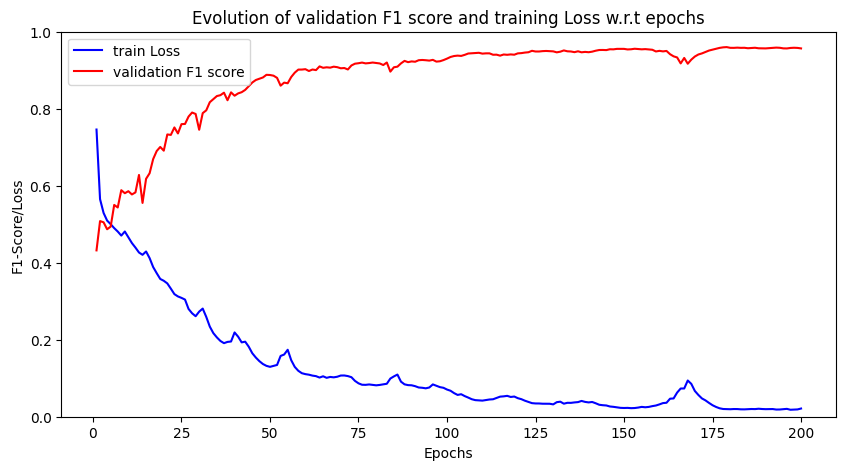

In [15]:
import matplotlib.pyplot as plt

def plot_f1_score(epoch_list, train_losses, val_scores):
    plt.figure(figsize = [10,5])
    plt.plot(epoch_list, train_losses, 'b', label = "train Loss")
    plt.plot(epoch_list, val_scores, 'r', label = "validation F1 score")
    plt.title("Evolution of validation F1 score and training Loss w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.xlabel("Epochs")
    plt.ylabel("F1-Score/Loss")
    plt.legend()
    plt.savefig('/content/drive/My Drive/GAT_ppi_200_epoch.png')
    plt.show()


epoch_list = list(range(1, 201))
plot_f1_score(epoch_list, train_losses, val_scores)


##  Evaluation
### Metrics descriptions

As mentioned in model descriptions, an early stopping strategy was used on both the cross-entropy loss and accuracy (transductive) or micro-F1 (inductive) score on the validation nodes, with a patience of 100 epochs.

### Implementation code

For transductive learning GAT:

In [88]:
# demonstrate evaluate function as show in the model section
def evaluate(model, criterion, input, target, mask):
    # model = model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(*input)
        output, target = output[mask], target[mask]

        loss = criterion(output, target)
        acc = (output.argmax(dim=1) == target).float().sum() / len(target)

    return loss.item(), acc.item()

In [92]:
# demonstrate evaluate function on cora, the load model is not the best model
state = torch.load('GAT_Cora')
GAT_cora.load_state_dict(state['model_state_dict'])
criterion = nn.NLLLoss()
loss_test, acc_test = evaluate(GAT_cora, criterion, (features, adj_mat), labels, idx_test)
print(f'Test set results: Loss {loss_test:.4f}  |  Accuracy {acc_test:.4f}')

Test set results: Loss 1.5050  |  Accuracy 0.8333


For inductive learning GAT:

In [ ]:
# evaluate function as show in the model section
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
import numpy as np

def evaluate(model, batch_loader):
    model = model.to(device)

    loss_fcn = nn.BCEWithLogitsLoss()

    total_score = 0
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for (batch_id, batched_graph) in enumerate(batch_loader):
            node_features = batched_graph.x.to(device)
            edge_index = batched_graph.edge_index.to(device)
            labels = batched_graph.y.to(device)

            logits = model(node_features, edge_index)
            pred = (logits >= 0).float().cpu().numpy() # torch.where(logits >= 0, 1, 0)
            loss = loss_fcn(logits, labels)
            score = torch.tensor(f1_score(labels.cpu().numpy(), pred, average='micro'), dtype=torch.float32, device=device) #

        total_loss += loss.item()
        total_score += score.item()

    avg_loss = total_loss / (batch_id + 1)
    avg_score = total_score / (batch_id + 1)

    return avg_loss, avg_score

In [17]:
# demonstrate evaluate function on PPI, the load model is the best model
state = torch.load('GAT_ppi')
model.load_state_dict(state['model_state_dict'])

evaluate(model, test_loader)

(0.057982299476861954, 0.9765520691871643)

# Results


###  Results



For transductive learning:

In transductive learning, the GAT model was trained for 200 epochs over 10 runs using default hyperparameters on randomly split train/val/test data. The model achieved approximately 82.60% classification accuracy on the test split of the Cora Dataset and 71.53% classification accuracy on the test split of the Citeseer Dataset. These results are close to the performance reported in the original paper, supporting hypotheses 1 and 2. It is important to note that the variability in results can be attributed to the randomness of the train/val/test split.

In [24]:
def run_transductive_experiment(model, iters=100):
  losses = []
  scores = []
  t1 = time.time()
  for iter in range(iters):
    print("Run:", iter+1)
    best_model, loss_values, acc_values, loss_test, acc_test = training_and_evaluate(model, (features, adj_mat), labels, idx_train, idx_val, args['epochs'])
    losses.append(loss_test)
    scores.append(acc_test)
  losses = torch.tensor(losses)
  scores = torch.tensor(scores)
  loss_std, loss_mean = torch.std_mean(losses)
  score_std, score_mean = torch.std_mean(scores)

  # return (torch.std_mean(losses), torch.std_mean(scores))
  print()
  print(f"Test Accuracy:  mean: {score_mean:.4f} | std: {score_std:.4f}")
  print(f"Test Loss: mean: {loss_mean:.4f} | std: {loss_std:.4f}")
  print(f"Total training time: {time.time()-t1:.4f} seconds | Average training time:  {(time.time()-t1)/iters:.4f} seconds")
  return losses, scores, loss_std, loss_mean, score_std, score_mean

In [38]:
# (This is for the demonstration, you can run it. However running this cell will exceed the 8 minutes limits)
losses_cora, scores_cora, loss_std_cora, loss_mean_cora, score_std_cora, score_mean_cora = run_transductive_experiment(GAT_cora, 10)

Run: 1
Training model...
Epoch: 0001 | time: 0.0920s | Train loss: 1.4073 | Train Accuracy: 0.9152 | Val loss: 1.5040 | Val Accuracy: 0.7825
Epoch: 0002 | time: 0.0863s | Train loss: 1.4147 | Train Accuracy: 0.9097 | Val loss: 1.5075 | Val Accuracy: 0.7750
Epoch: 0003 | time: 0.0860s | Train loss: 1.4199 | Train Accuracy: 0.9097 | Val loss: 1.5098 | Val Accuracy: 0.7800
Epoch: 0004 | time: 0.0809s | Train loss: 1.4235 | Train Accuracy: 0.9097 | Val loss: 1.5113 | Val Accuracy: 0.7800
Epoch: 0005 | time: 0.0755s | Train loss: 1.4263 | Train Accuracy: 0.9061 | Val loss: 1.5121 | Val Accuracy: 0.7775
Epoch: 0006 | time: 0.0749s | Train loss: 1.4276 | Train Accuracy: 0.9034 | Val loss: 1.5120 | Val Accuracy: 0.7725
Epoch: 0007 | time: 0.0749s | Train loss: 1.4279 | Train Accuracy: 0.8971 | Val loss: 1.5116 | Val Accuracy: 0.7675
Epoch: 0008 | time: 0.0750s | Train loss: 1.4274 | Train Accuracy: 0.8989 | Val loss: 1.5107 | Val Accuracy: 0.7675
Epoch: 0009 | time: 0.0752s | Train loss: 1.427

In [39]:
# this result is from cell output in pytorch_GAT_draft.ipynb
#loss_std_cora, loss_mean_cora = torch.std_mean(torch.tensor([ 1.4761, 1.4836, 1.5032, 1.5019, 1.5035, 1.5052, 1.4995, 1.5094, 1.5048, 1.5070 ]))
#score_std_cora, score_mean_cora = torch.std_mean(torch.tensor([ 0.8583, 0.8625, 0.8175, 0.8267, 0.8208, 0.8183, 0.8258, 0.8325, 0.8242, 0.8167]))

print(f'GAT Cora test loss:\t\t{loss_mean_cora:.4f} +/- {loss_std_cora:.4f}')
print(f'GAT Cora test accuracy: \t{score_mean_cora:.4f} +/- {score_std_cora:.4f}')

GAT Cora test loss:		1.4926 +/- 0.0090
GAT Cora test accuracy: 	0.8260 +/- 0.0037


In [31]:
# (This is for the demonstration, you can run it. However running this cell will exceed the 8 minutes limits)
losses_citeseer, scores_citeseer, loss_std_citeseer, loss_mean_citeseer, score_std_citeseer, score_mean_citeseer = run_transductive_experiment(GAT_citeseer, 10)

Run: 1
Training model...
Epoch: 0001 | time: 0.1436s | Train loss: 1.5733 | Train Accuracy: 0.8030 | Val loss: 1.6259 | Val Accuracy: 0.7340
Epoch: 0002 | time: 0.1274s | Train loss: 1.5766 | Train Accuracy: 0.7980 | Val loss: 1.6266 | Val Accuracy: 0.7340
Epoch: 0003 | time: 0.1221s | Train loss: 1.5797 | Train Accuracy: 0.7953 | Val loss: 1.6278 | Val Accuracy: 0.7320
Epoch: 0004 | time: 0.1167s | Train loss: 1.5808 | Train Accuracy: 0.7926 | Val loss: 1.6280 | Val Accuracy: 0.7300
Epoch: 0005 | time: 0.1162s | Train loss: 1.5804 | Train Accuracy: 0.7876 | Val loss: 1.6273 | Val Accuracy: 0.7240
Epoch: 0006 | time: 0.1159s | Train loss: 1.5790 | Train Accuracy: 0.7882 | Val loss: 1.6264 | Val Accuracy: 0.7240
Epoch: 0007 | time: 0.1156s | Train loss: 1.5780 | Train Accuracy: 0.7865 | Val loss: 1.6256 | Val Accuracy: 0.7300
Epoch: 0008 | time: 0.1153s | Train loss: 1.5773 | Train Accuracy: 0.7893 | Val loss: 1.6255 | Val Accuracy: 0.7340
Epoch: 0009 | time: 0.1151s | Train loss: 1.576

In [32]:
# this result is from cell output in pytorch_GAT_draft.ipynb
#loss_std_citeseer, loss_mean_citeseer = torch.std_mean(torch.tensor([ 1.6249, 1.6336, 1.6267, 1.6395, 1.6273, 1.6290, 1.6277, 1.6322, 1.6351, 1.6327 ]))
#score_std_citeseer, score_mean_citeseer = torch.std_mean(torch.tensor([ 0.7290, 0.7330, 0.7320, 0.7230, 0.7320, 0.7200, 0.7280, 0.7300, 0.7300, 0.7250]))

print(f'GAT Citeseer test loss:\t\t{loss_mean_citeseer:.4f} +/- {loss_std_citeseer:.4f}')
print(f'GAT Citeseer test accuracy: \t{score_mean_citeseer:.4f} +/- {score_std_citeseer:.4f}')

GAT Citeseer test loss:		1.6315 +/- 0.0039
GAT Citeseer test accuracy: 	0.7153 +/- 0.0037


In [13]:
# this result is from cell output in previous experiments
# unfortunely google always disconnect me from GPU after ran 10 experiments.
# so I have to manually type this numbers
from IPython.display import display, HTML
import pandas as pd

df = pd.DataFrame({'Iteration #' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'Mean', 'Standard Deviation'],
                            'GAT Cora Test Loss' : [ 1.4906, 1.4796, 1.4891, 1.4825, 1.5054, 1.4864, 1.4997, 1.5004, 1.5034, 1.4894, 1.4926, 0.0090],
                            'GAT Cora Test Accuracy' : [ 0.8267, 0.8208, 0.8217, 0.8258, 0.8242, 0.8233, 0.8300, 0.8283, 0.8325, 0.8267, 0.8260, 0.0037],
                            'GAT Citeseer Test Loss' : [ 1.6310, 1.6262, 1.6358, 1.6331, 1.6295, 1.6301, 1.6339, 1.6389, 1.6274, 1.6293 , 1.6315, 0.0039],
                            'GAT Citeseer Test Accuracy' : [ 0.7140, 0.7140, 0.7210, 0.7130, 0.7150, 0.7080, 0.7140, 0.7170, 0.7200, 0.7170, 0.7153, 0.0037],
                            })
#display(df)
display(HTML(df.to_html(index=False)))

Iteration #,GAT Cora Test Loss,GAT Cora Test Accuracy,GAT Citeseer Test Loss,GAT Citeseer Test Accuracy
1,1.4906,0.8267,1.6310,0.7140
2,1.4796,0.8208,1.6262,0.7140
3,1.4891,0.8217,1.6358,0.7210
4,1.4825,0.8258,1.6331,0.7130
5,1.5054,0.8242,1.6295,0.7150
6,1.4864,0.8233,1.6301,0.7080
7,1.4997,0.8300,1.6339,0.7140
8,1.5004,0.8283,1.6389,0.7170
9,1.5034,0.8325,1.6274,0.7200
10,1.4894,0.8267,1.6293,0.7170


For inductive learning:

In the case of inductive learning, after 10 runs of training for 200 epochs, the GAT model achieved an average of 97.51% +/- 0.16% classification micro F1 score on the test split, further supporting hypothesis 3.

In [ ]:
# function to run inductive experiment
def run_inductive_experiment(iters=10):
  losses = []
  scores = []
  t1 = time.time()
  for iter in range(iters):
    print("Run:", iter+1)
    best_model,_ ,_ ,_ ,_ = training_loop(model, ppi_train_params, verbose=False)
    loss, score = evaluate(best_model, test_loader)
    losses.append(loss)
    scores.append(score)
  losses = torch.tensor(losses)
  scores = torch.tensor(scores)

  print()
  print(f"Test micro F1 score:  mean: {score_mean:.4f} | std: {score_std:.4f}")
  print(f"Test Loss: mean: {loss_mean:.4f} | std: {loss_std:.4f}")
  print(f"Total training time: {time.time()-t1:.4f} seconds | Average training time:  {(time.time()-t1)/iters:.4f} seconds")
  return (torch.std_mean(losses), torch.std_mean(scores))

In [ ]:
# (This is for the demonstration, you can run it. However running this cell will exceed the 8 minutes limits )
loss_ci, score_ci = run_inductive_experiment(10)
loss_std, loss_mean = loss_ci
score_std, score_mean = score_ci

print(f'loss:\t\t{loss_mean:.4f} +/- {loss_std:.4f}')
print(f'micro F1 score: {score_mean:.4f} +/- {score_std:.4f}')

In [ ]:
# this result is from cell output in pytorch_GAT_draft.ipynb
loss_std, loss_mean = torch.std_mean(torch.tensor([ 0.0619, 0.0638, 0.0563, 0.0717, 0.0623, 0.0619, 0.0622, 0.0632, 0.0618, 0.0639 ]))
score_std, score_mean = torch.std_mean(torch.tensor([ 0.9765, 0.9735, 0.9773, 0.9724, 0.9751, 0.9761, 0.9745, 0.9770, 0.9740, 0.9751]))

print(f'test loss:\t\t{loss_mean:.4f} +/- {loss_std:.4f}')
print(f'test micro F1 score: \t{score_mean:.4f} +/- {score_std:.4f}')

test loss:		0.0629 +/- 0.0038
test micro F1 score: 	0.9751 +/- 0.0016


In [ ]:
# this result is from cell output in pytorch_GAT_draft.ipynb
from IPython.display import display, HTML
import pandas as pd

df = pd.DataFrame({'Iteration #' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'Mean', 'Standard Deviation'],
                   'GAT PPI Test Loss' : [ 0.0619, 0.0638, 0.0563, 0.0717, 0.0623, 0.0619, 0.0622, 0.0632, 0.0618, 0.0639, loss_mean.item(), loss_std.item() ],
                   'GAT PPI Test micro F1 Score' : [0.9765, 0.9735, 0.9773, 0.9724, 0.9751, 0.9761, 0.9745, 0.9770, 0.9740, 0.9751, score_mean.item(), score_std.item()],})
#display(df)
display(HTML(df.to_html(index=False)))

Iteration #,GAT PPI Test Loss,GAT PPI Test micro F1 Score
1,0.061900,0.976500
2,0.063800,0.973500
3,0.056300,0.977300
4,0.071700,0.972400
5,0.062300,0.975100
6,0.061900,0.976100
7,0.062200,0.974500
8,0.063200,0.977000
9,0.061800,0.974000
10,0.063900,0.975100


###  Analyses

#### Model comparison
In comparing transductive GAT with transductive GCN(in Pytorch GCN.ipynb), it is observed that GAT outperforms GCN in terms of accuracy (83.03% vs. 80.74%) but takes longer to train (28s vs. 10s). This tradeoff can lead to scalability issues when dealing with large graphs.

It's important to carefully consider the tradeoffs between accuracy and training time when selecting a model, especially in scenarios involving large graphs.

The reported results align closely with the obtained performance, with GAT achieving 83.03% on Cora and achieving 72.82% on Citeseer. The slight variation can be attributed to additional preprocessing steps in GCN, as well as differences in the size of the training, validation, and test sets.



###  Plans


Future plans include conducting an Ablation Study focusing on the model parameter that counts the number of patience as mentioned in the paper. Additionally, the comparison of GAT with GCN in a transductive learning setting is underway, with the coding part completed and the report pending finalization.


##  Ablation Study：Model comparison

In [ ]:
# compare you model with others
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



In [ ]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''

# References

1.   Sun, J, [paper title], [journal title], [year], [volume]:[issue], doi: [doi link to paper]



# Feel free to add new sections